# Dirichlet Prior Networks (DPNs): Unified Training Example

This notebook provides a complete implementation of **Dirichlet Prior Networks (DPNs)** as introduced
by Malinin & Gales (2018). DPNs explicitly model predictive uncertainty by learning a Dirichlet
distribution over class probabilities.

The key idea is to enforce:
- **sharp Dirichlet distributions** for in-distribution (ID) data,
- **flat Dirichlet distributions** for out-of-distribution (OOD) data.

Training follows the original Prior Networks formulation using:
- sharp Dirichlet targets for ID samples,
- flat Dirichlet targets for OOD samples,
- KL divergence between target and predicted Dirichlet distributions.

This notebook is structured into the following sections:

1. Imports & Setup  
2. Data Preparation  
3. Model Definition  
4. Dirichlet Target Construction  
5. Unified DPN Training Function  
6. Training Loop  
7. Evaluation & Uncertainty Analysis  
8. Sanity Checks 

### 1. Imports & Setup

This section imports all libraries required to define, train, and evaluate a Dirichlet Prior Network.

We use:
- **PyTorch** for model definition and training,
- **torchvision** for dataset handling,
- **NumPy / scikit-learn** for evaluation utilities,
- **probly** for unified evidential training and loss functions.

Additionally, the computation device (CPU or GPU) is detected automatically.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.special import digamma, gammaln
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from probly.losses.evidential.torch import pn_loss
from probly.train.evidential.torch import unified_evidential_train

# Select computation device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2. Data Preparation

Dirichlet Prior Networks require **two datasets during training**:

- an **in-distribution (ID)** dataset, used to encourage *sharp* Dirichlet predictions,
- an **out-of-distribution (OOD)** dataset, used to encourage *flat* Dirichlet predictions.

Following the original Prior Networks setup, we use:
- **MNIST** as the ID dataset,
- **Fashion-MNIST** as the OOD dataset.

Both datasets are preprocessed identically:
- images are converted to tensors,
- pixel values are normalized to ensure consistent feature scaling.


In [27]:
# Transformation: convert images to tensors and normalize pixel values
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)

# In-distribution dataset (MNIST)
train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

# Out-of-distribution dataset (Fashion-MNIST)
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)
ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print(f"Loaded MNIST (ID) with {len(train_data)} training samples.")
print(f"Loaded Fashion-MNIST (OOD) with {len(ood_data)} samples.")

Loaded MNIST (ID) with 60000 training samples.
Loaded Fashion-MNIST (OOD) with 10000 samples.


### 3. Model Definition

A Dirichlet Prior Network outputs **Dirichlet concentration parameters**
$\alpha \in \mathbb{R}_+^K$ for $K$ classes.

These parameters define a Dirichlet distribution over categorical class probabilities.

The model implemented here consists of:
- a **convolutional feature extractor**,
- a **fully-connected classifier head**,
- a **softplus activation** ensuring $\alpha_k > 0$ for all classes.

This architecture is sufficient for MNIST-scale experiments and reflects the
standard structure used in the DPN literature.

In [28]:
class ConvEncoder(nn.Module):
    """Convolutional encoder mapping images to latent feature representations."""

    def __init__(
        self,
        in_channels: int,
        conv_channels: list[int],
        latent_dim: int,
        input_shape: tuple[int, int],
    ) -> None:
        """Initialize the convolutional encoder.

        Args:
            in_channels: Number of input channels.
            conv_channels: List of convolutional channel sizes.
            latent_dim: Dimensionality of the latent feature space.
            input_shape: Spatial input shape (H, W).
        """
        super().__init__()

        layers = []
        c_in = in_channels

        # Build convolutional feature extractor
        for c_out in conv_channels:
            layers.extend(
                [
                    nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                ]
            )
            c_in = c_out

        self.features = nn.Sequential(*layers)

        # Infer flattened feature dimension dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, *input_shape)
            feat = self.features(dummy)
            flattened_dim = feat.view(1, -1).size(1)

        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, latent_dim),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Encode inputs into latent feature representations.

        Args:
            x: Input image batch.

        Returns:
            Latent feature tensor.
        """
        x = self.features(x)
        return self.projection(x)


class PrNetHead(nn.Module):
    """Dirichlet Prior Network head producing concentration parameters."""

    def __init__(self, latent_dim: int, num_classes: int) -> None:
        """Initialize the Dirichlet classification head.

        Args:
            latent_dim: Dimensionality of the latent feature space.
            num_classes: Number of output classes.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Produce Dirichlet concentration parameters alpha > 0."""
        return F.softplus(self.net(z)) + 1e-3


class PrNetModel(nn.Module):
    """Dirichlet Prior Network model for evidential classification.

    Combines an encoder with a Dirichlet Prior Network head to model
    distributional uncertainty following Malinin and Gales (2018).

    Reference:
        Malinin and Gales, "Predictive Uncertainty Estimation via Prior Networks",
        NeurIPS 2018.
        https://arxiv.org/abs/1802.10501
    """

    def __init__(
        self,
        encoder: nn.Module,
        head: nn.Module | None = None,
        latent_dim: int = 256,
        num_classes: int = 10,
    ) -> None:
        """Initialize the Dirichlet Prior Network model.

        Args:
            encoder: Encoder module mapping inputs to latent space.
            head: Dirichlet Prior Network head producing concentration parameters.
                If None, defaults to ``t.PrNetHead``.
            latent_dim: Dimensionality of the latent space.
            num_classes: Number of output classes.
        """
        super().__init__()

        if head is None:
            head = PrNetHead(
                latent_dim=latent_dim,
                num_classes=num_classes,
            )

        self.encoder = encoder
        self.head = head

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute Dirichlet parameters for input samples."""
        features = self.encoder(x)
        return self.head(features)

### 4. Dirichlet Target Construction

Training a Dirichlet Prior Network requires **explicit target Dirichlet distributions**
for both in-distribution (ID) and out-of-distribution (OOD) samples.

Following the Prior Networks formulation, we distinguish two target types:

- **In-distribution (ID)** targets:
  - sharp Dirichlet distributions,
  - high total concentration (α₀),
  - mass concentrated on the ground-truth class.

- **Out-of-distribution (OOD)** targets:
  - flat Dirichlet distributions,
  - low total concentration (α₀),
  - uniform mass across all classes.

These targets are used during training to minimise the KL divergence between
target and predicted Dirichlet distributions.

In [29]:
# ------------------------------------------------------------------
# Dirichlet target configuration
# ------------------------------------------------------------------

# Total concentration (precision) for in-distribution targets
alpha0_in = 100.0

# Total concentration (precision) for out-of-distribution targets
alpha0_ood = 10.0

# Label smoothing for numerical stability
label_smoothing = 0.01


def make_in_domain_target_alpha(
    y: torch.Tensor,
    num_classes: int = 10,
    alpha0: float = alpha0_in,
) -> torch.Tensor:
    """Construct sharp Dirichlet targets for in-distribution samples.

    For each sample, a smoothed one-hot distribution is created and
    scaled to a high total concentration α₀.

    Args:
        y: Ground-truth class labels of shape (B,).
        num_classes: Number of classes.
        alpha0: Total concentration (precision) of the Dirichlet target.

    Returns:
        Dirichlet concentration parameters with shape (B, num_classes).
    """
    batch_size = y.size(0)

    # Smoothed one-hot mean vector
    mu = torch.full(
        (batch_size, num_classes),
        label_smoothing / (num_classes - 1),
        device=y.device,
    )
    mu[torch.arange(batch_size), y] = 1.0 - label_smoothing

    # Scale mean vector to desired total concentration
    return mu * alpha0


def make_ood_target_alpha(
    batch_size: int,
    num_classes: int = 10,
    alpha0: float = alpha0_ood,
) -> torch.Tensor:
    """Construct flat Dirichlet targets for out-of-distribution samples.

    OOD targets correspond to a uniform Dirichlet distribution with
    low total concentration.

    Args:
        batch_size: Number of OOD samples.
        num_classes: Number of classes.
        alpha0: Total concentration (precision) of the Dirichlet target.

    Returns:
        Dirichlet concentration parameters with shape (B, num_classes).
    """
    mu = torch.full(
        (batch_size, num_classes),
        1.0 / num_classes,
        device=device,
    )

    return mu * alpha0

### 5. Unified DPN Training Function

Training a Dirichlet Prior Network requires **joint optimisation on
in-distribution (ID) and out-of-distribution (OOD) data**.

Following Malinin & Gales (2018), the training objective consists of:

1. **ID loss**  
   KL divergence between sharp Dirichlet targets and predicted Dirichlets.

2. **OOD loss**  
   KL divergence between flat Dirichlet targets and predicted Dirichlets.

3. **Optional classification stability term**  
   Cross-entropy on the expected categorical distribution.

This section defines helper functions and a unified training routine
that performs **one full training epoch** using paired ID and OOD batches.

In [30]:
def kl_dirichlet(alpha_p: torch.Tensor, alpha_q: torch.Tensor) -> torch.Tensor:
    """Compute KL(Dir(alpha_p) || Dir(alpha_q)) per sample.

    Args:
        alpha_p: Target Dirichlet parameters.
        alpha_q: Predicted Dirichlet parameters.

    Returns:
        KL divergence for each sample in the batch.
    """
    alpha_p0 = alpha_p.sum(dim=-1, keepdim=True)
    alpha_q0 = alpha_q.sum(dim=-1, keepdim=True)

    term1 = gammaln(alpha_p0) - gammaln(alpha_q0)
    term2 = (gammaln(alpha_q) - gammaln(alpha_p)).sum(dim=-1, keepdim=True)
    term3 = ((alpha_p - alpha_q) * (digamma(alpha_p) - digamma(alpha_p0))).sum(dim=-1, keepdim=True)

    return (term1 + term2 + term3).squeeze(-1)


def predictive_probs(alpha: torch.Tensor) -> torch.Tensor:
    """Compute expected categorical probabilities E[p(y|x)].

    Args:
        alpha: Dirichlet concentration parameters.

    Returns:
        Expected categorical probabilities.
    """
    alpha0 = alpha.sum(dim=-1, keepdim=True)
    return alpha / alpha0


def unified_dpn_train_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    id_loader: DataLoader,
    ood_loader: DataLoader,
) -> float:
    """Train the model for one epoch using paired ID and OOD mini-batches.

    Args:
        model: Dirichlet Prior Network model.
        optimizer: Optimizer for parameter updates.
        id_loader: DataLoader for in-distribution data.
        ood_loader: DataLoader for out-of-distribution data.

    Returns:
        Average training loss for the epoch.
    """
    model.train()

    total_loss = 0.0
    total_batches = 0

    # Create an iterator over the OOD loader
    ood_iter = iter(ood_loader)

    for x_id_raw, y_id_raw in id_loader:
        try:
            x_ood_raw, _ = next(ood_iter)
        except StopIteration:
            # Restart OOD iterator if exhausted
            ood_iter = iter(ood_loader)
            x_ood_raw, _ = next(ood_iter)

        x_id = x_id_raw.to(device)
        y_id = y_id_raw.to(device)
        x_ood = x_ood_raw.to(device)

        optimizer.zero_grad()

        # --------------------------------------------------
        # In-distribution forward pass
        # --------------------------------------------------
        alpha_id = model(x_id)
        alpha_target_id = make_in_domain_target_alpha(y_id)
        kl_id = kl_dirichlet(alpha_target_id, alpha_id).mean()

        # Optional classification stability term
        probs_id = predictive_probs(alpha_id)
        ce_term = F.nll_loss(torch.log(probs_id + 1e-8), y_id)

        # --------------------------------------------------
        # Out-of-distribution forward pass
        # --------------------------------------------------
        alpha_ood = model(x_ood)
        alpha_target_ood = make_ood_target_alpha(x_ood.size(0))
        kl_ood = kl_dirichlet(alpha_target_ood, alpha_ood).mean()

        # --------------------------------------------------
        # Total loss and optimisation step
        # --------------------------------------------------
        loss = kl_id + kl_ood + 0.1 * ce_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    return total_loss / total_batches

### 6. Training Loop

This section instantiates the Dirichlet Prior Network model and starts the
training process using the unified evidential training routine.

Following the same pattern as in the EDL example, we:
- define an encoder,
- build the Prior Network model,
- specify the loss function,
- start the unified training loop.

The training jointly optimises the model on in-distribution (MNIST) and
out-of-distribution (Fashion-MNIST) data.

In [ ]:
# Initialize loss function
loss = pn_loss

# Define encoder
enc = ConvEncoder(
    in_channels=1,
    conv_channels=[32, 64, 128],
    latent_dim=256,
    input_shape=(28, 28),
)

# Build Dirichlet Prior Network model
model = PrNetModel(encoder=enc).to(device=device)

# Start unified evidential training
unified_evidential_train(
    mode="PrNet",
    model=model,
    dataloader=train_loader,
    loss_fn=loss,
    oodloader=ood_loader,
)

Epoch [1/5] - Loss: 1.4470
Epoch [2/5] - Loss: 0.3345
Epoch [3/5] - Loss: 0.2451
Epoch [4/5] - Loss: 0.2006
Epoch [5/5] - Loss: 0.1777


### 7. Evaluation: Accuracy & Predictive Distribution

After training, the Dirichlet Prior Network can be evaluated using the
**predictive categorical distribution**, given by the mean of the Dirichlet:

$$
\mathbb{E}[p(y \mid x)] = \frac{\alpha}{\alpha_0},
\qquad
\alpha_0 = \sum_k \alpha_k.
$$

Using this predictive distribution, standard classification metrics such as
accuracy can be computed. This section evaluates the model on the MNIST
test set using predictive accuracy.


In [ ]:
def evaluate_accuracy(
    model: nn.Module,
    loader: DataLoader,
) -> float:
    """Evaluate predictive accuracy using Dirichlet mean probabilities.

    Args:
        model: Trained Dirichlet Prior Network model.
        loader: DataLoader providing evaluation data.

    Returns:
        Predictive classification accuracy.
    """
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x_raw, y_raw in loader:
            x = x_raw.to(device)
            y = y_raw.to(device)

            # Forward pass: obtain Dirichlet parameters
            alpha = model(x)

            # Predictive categorical distribution
            alpha0 = alpha.sum(dim=-1, keepdim=True)
            probs = alpha / alpha0

            # Predicted class labels
            preds = probs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"Predictive accuracy: {acc:.4f}")

    return acc


# Evaluate ID accuracy
id_accuracy = evaluate_accuracy(model, test_loader)
id_accuracy

Predictive accuracy: 0.9925


0.9925

### 8. Uncertainty Analysis: Predictive and Differential Entropy

Dirichlet Prior Networks provide uncertainty estimates through the structure
of the predicted Dirichlet distribution.

Two complementary uncertainty measures are commonly used:

1. **Predictive entropy**  
   Defined on the expected categorical distribution
   $$
   p(y \mid x) = \frac{\alpha}{\alpha_0},
   \qquad
   H_{\text{pred}} = -\sum_k p_k \log p_k,
   $$
   capturing total predictive uncertainty.

2. **Dirichlet differential entropy**  
   Defined on the full Dirichlet distribution
   $$
   H_{\text{dir}} = H(\mathrm{Dir}(\alpha)),
   $$
   capturing epistemic uncertainty via the concentration of $\alpha$.

In-distribution (MNIST) samples are expected to yield:
- low predictive entropy,
- low differential entropy.

Out-of-distribution (Fashion-MNIST) samples are expected to yield:
- high predictive entropy,
- high differential entropy.

In [34]:
def predictive_entropy(alpha: torch.Tensor) -> torch.Tensor:
    """Compute predictive entropy from Dirichlet parameters.

    Args:
        alpha: Dirichlet concentration parameters.

    Returns:
        Predictive entropy for each sample.
    """
    alpha0 = alpha.sum(dim=-1, keepdim=True)
    p = alpha / alpha0
    return -(p * torch.log(p + 1e-8)).sum(dim=-1)


def dirichlet_differential_entropy(alpha: torch.Tensor) -> torch.Tensor:
    """Compute differential entropy of a Dirichlet distribution.

    Args:
        alpha: Dirichlet concentration parameters.

    Returns:
        Differential entropy for each sample.
    """
    alpha0 = alpha.sum(dim=-1)
    k = alpha.size(-1)

    log_b = gammaln(alpha).sum(dim=-1) - gammaln(alpha0)
    digamma_alpha = digamma(alpha)
    digamma_alpha0 = digamma(alpha0)

    return log_b + (alpha0 - k) * digamma_alpha0 - ((alpha - 1) * digamma_alpha).sum(dim=-1)


def compute_alpha(
    model: nn.Module,
    loader: DataLoader,
) -> torch.Tensor:
    """Compute Dirichlet parameters alpha(x) for all samples in a DataLoader.

    Args:
        model: Trained Dirichlet Prior Network model.
        loader: DataLoader providing input data.

    Returns:
        Concatenated Dirichlet parameters for all samples.
    """
    model.eval()
    out = []

    with torch.no_grad():
        for x_raw, _ in loader:
            x = x_raw.to(device)
            out.append(model(x).cpu())

    return torch.cat(out, dim=0)

In [35]:
# Compute Dirichlet parameters for ID and OOD sets
alpha_id = compute_alpha(model, test_loader)
alpha_ood = compute_alpha(model, ood_loader)

# Predictive entropy
pred_ent_id = predictive_entropy(alpha_id)
pred_ent_ood = predictive_entropy(alpha_ood)

# Dirichlet differential entropy
diff_ent_id = dirichlet_differential_entropy(alpha_id)
diff_ent_ood = dirichlet_differential_entropy(alpha_ood)

pred_ent_id.mean().item(), pred_ent_ood.mean().item()

(1.7403826713562012, 2.3004937171936035)

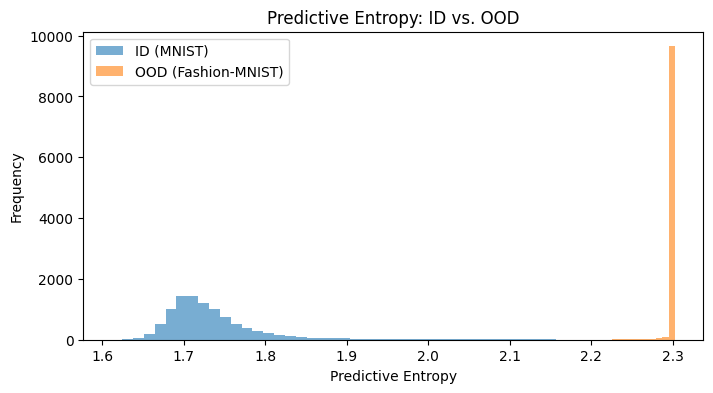

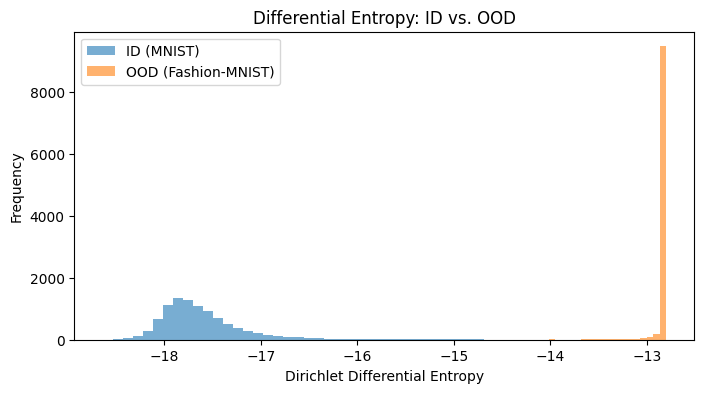

In [36]:
# Predictive entropy histograms
plt.figure(figsize=(8, 4))
plt.hist(pred_ent_id.numpy(), bins=50, alpha=0.6, label="ID (MNIST)")
plt.hist(pred_ent_ood.numpy(), bins=50, alpha=0.6, label="OOD (Fashion-MNIST)")
plt.xlabel("Predictive Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.title("Predictive Entropy: ID vs. OOD")
plt.show()

# Dirichlet differential entropy histograms
plt.figure(figsize=(8, 4))
plt.hist(diff_ent_id.numpy(), bins=50, alpha=0.6, label="ID (MNIST)")
plt.hist(diff_ent_ood.numpy(), bins=50, alpha=0.6, label="OOD (Fashion-MNIST)")
plt.xlabel("Dirichlet Differential Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.title("Differential Entropy: ID vs. OOD")
plt.show()

### 9. Sanity Checks

Before using the trained Dirichlet Prior Network for downstream tasks,
we perform a set of sanity checks to verify that the model behaves
according to the Prior Networks formulation.

Specifically, we check that:

1. all predicted Dirichlet parameters $\alpha(x)$ are strictly positive,
2. in-distribution samples yield higher total concentration $\alpha_0$ than OOD samples,
3. predictive entropy is lower for ID samples than for OOD samples,
4. differential entropy is higher for OOD samples, reflecting epistemic uncertainty.

These checks help validate both the implementation and the training procedure.

In [37]:
# Check 1: (alpha)(x) > 0 for all samples
min_alpha_id = alpha_id.min().item()
min_alpha_ood = alpha_ood.min().item()

# alpha_id must be strictly positive for a valid Dirichlet distribution
if min_alpha_id <= 0.0:
    msg = "alpha_id is non-positive"
    raise ValueError(msg)

# alpha_ood must be strictly positive for a valid Dirichlet distribution
if min_alpha_ood <= 0.0:
    msg = "alpha_ood is non-positive"
    raise ValueError(msg)

print("Minimum alpha (ID):", min_alpha_id)
print("Minimum alpha (OOD):", min_alpha_ood)

Minimum alpha (ID): 0.5390748381614685
Minimum alpha (OOD): 0.5812780857086182


In [38]:
# Concentration α₀ = Σ_k (alpha)_k
alpha0_id = alpha_id.sum(dim=1)
alpha0_ood = alpha_ood.sum(dim=1)

print("Mean α₀ (ID): ", alpha0_id.mean().item())
print("Mean α₀ (OOD):", alpha0_ood.mean().item())

Mean α₀ (ID):  18.763912200927734
Mean α₀ (OOD): 10.052386283874512


In [39]:
print("Predictive entropy (ID, mean): ", pred_ent_id.mean().item())
print("Predictive entropy (OOD, mean):", pred_ent_ood.mean().item())

print("Differential entropy (ID, mean): ", diff_ent_id.mean().item())
print("Differential entropy (OOD, mean):", diff_ent_ood.mean().item())

Predictive entropy (ID, mean):  1.7403826713562012
Predictive entropy (OOD, mean): 2.3004937171936035
Differential entropy (ID, mean):  -17.562355041503906
Differential entropy (OOD, mean): -12.829889297485352


In [40]:
# OOD detection performance using predictive entropy (ROC AUC).
y_true = np.concatenate(
    [
        np.zeros_like(pred_ent_id.numpy()),
        np.ones_like(pred_ent_ood.numpy()),
    ],
)
y_scores = np.concatenate(
    [
        pred_ent_id.numpy(),
        pred_ent_ood.numpy(),
    ],
)

auc = roc_auc_score(y_true, y_scores)
print(f"OOD AUC (predictive entropy): {auc:.4f}")

OOD AUC (predictive entropy): 1.0000


Conclusion
----------

This notebook presented a complete implementation of Dirichlet Prior Networks (DPNs) following
the formulation introduced by Malinin & Gales (2018). The model produces Dirichlet
concentration parameters for each input, enabling principled uncertainty estimation via:

- sharp Dirichlet distributions for in-distribution samples,
- flat Dirichlet distributions for out-of-distribution samples,
- KL divergence between target and predicted Dirichlet distributions.

The experiments demonstrated the characteristic behaviour of DPNs: low predictive and
differential entropy for MNIST (ID) and high entropy for Fashion-MNIST (OOD). The included
sanity checks verified that the model adheres to the expected properties of Prior Networks.

The implementation presented here serves as a reference for applying Dirichlet Prior Networks
in settings that require calibrated predictive uncertainty and explicit modelling of
out-of-distribution behaviour.